In [1]:
import matplotlib.pyplot as plt
from netrc import netrc
import numpy as np
from onc import ONC
from typing import NamedTuple
import warnings

_,__,token = netrc().authenticators("data.oceannetworks.ca")

## Helper Functions

In [2]:
FILL_VALUE = -9999

class SynchronizedFrame(NamedTuple):
    """
    A structure representing a parsed FullASCII frame of a SUNAv2 instrument.

    Note that this structure is slightly different from the style and naming conventions described in the SUNAv2
    manual. For example, the frame type and serial number are separated into different fields.
    """
    frame_type: str  # The frame  descriptor. For FullASCII frames this will either be SATSDF (dark) or SATSLF (light).
    instrument_sn: str  # The zero-padded serial number of the SUNAv2.
    instrument_date: int  # The date of the instrument in the format YYYYJJJ, where JJJ is the Julian day of the year.
    instrument_time: float  # The floating point time of in the instrument in hours based on a 24 hour clock.
    nitrate_concentration_uncorrected: float  # Nitrate uncorrected for the effects of temperature, salinity, and pressure.
    nitrogen_in_nitrate_uncorrected: float
    absorbance_254nm: float
    absorbance_350nm: float
    bromide_trace: float
    spectrum_average: int
    fit_dark: int
    integration_time_factor: int
    detector_intensity: list[int]
    internal_temperature: float
    spectrometer_temperature: float
    lamp_temperature: float
    lamp_on_time: int
    internal_relative_humidity: float
    main_voltage: float
    lamp_voltage: float
    internal_voltage: float
    main_current: float
    fit_aux_1: float
    fit_aux_2: float
    fit_base_1: float
    fit_base_2: float
    fit_rmse: float

    # ONC does not (and should not) connect a CTD to the SUNAv2, so this data can be discarded later.
    connected_ctd_time: float | int
    connected_ctd_practical_salinity: float | int
    connected_ctd_temperature: float | int
    connected_ctd_pressure: float | int

    checksum: int


def parse_frame(frame: str) -> SynchronizedFrame:
        parts = frame.split(',')

        # Scuffed checker for frame completeness. Should have at least 286 comma-separated parts.
        # According to the manual, a frame checksum may change after values are collected?
        if len(parts) < 286:
            warnings.warn(f'Incomplete frame: {frame}')
            return None

        sf = SynchronizedFrame(frame_type=parts[0][0:6],
                               instrument_sn=parts[0][6:],
                               instrument_date=int(parts[1]),
                               instrument_time=float(parts[2]),
                               nitrate_concentration_uncorrected=float(parts[3]),
                               nitrogen_in_nitrate_uncorrected=float(parts[4]),
                               absorbance_254nm=float(parts[5]),
                               absorbance_350nm=float(parts[6]),
                               bromide_trace=float(parts[7]),
                               spectrum_average=int(parts[8]),
                               fit_dark =int(parts[9]),
                               integration_time_factor=int(parts[10]),
                               detector_intensity=[int(v) for v in parts[11:-19]],  # Expectation is a list of 256 integers.
                               internal_temperature=float(parts[-19]),
                               spectrometer_temperature=float(parts[-18]),
                               lamp_temperature=float(parts[-17]),
                               lamp_on_time=int(parts[-16]),
                               internal_relative_humidity=float(parts[-15]),
                               main_voltage=float(parts[-14]),
                               lamp_voltage=float(parts[-13]),
                               internal_voltage=float(parts[-12]),
                               main_current=float(parts[-11]),
                               fit_aux_1=float(parts[-10]),
                               fit_aux_2=float(parts[-9]),
                               fit_base_1=float(parts[-8]),
                               fit_base_2=float(parts[-7]),
                               fit_rmse=float(parts[-6]),
                               connected_ctd_time=int(parts[-5]) if len(parts[-5]) > 0 else FILL_VALUE,
                               connected_ctd_practical_salinity=float(parts[-4]) if len(
                                   parts[-4]) > 0 else FILL_VALUE,
                               connected_ctd_temperature=float(parts[-3]) if len(parts[-3]) > 0 else FILL_VALUE,
                               connected_ctd_pressure=float(parts[-2]) if len(parts[-2]) > 0 else FILL_VALUE,
                               checksum=int(parts[-1].strip()))
        return sf

## Data Request

In [3]:
onc = ONC(token=token)

In [4]:
locationCode = 'BACVP'
deviceCategoryCode = 'NITRATESENSOR'
dateFrom = '2025-09-23T22:00:00.000Z'


params = {'locationCode': locationCode,
          'deviceCategoryCode': deviceCategoryCode,
          'dateFrom': dateFrom}

json_data = onc.getRawdata(params)

## Pull out the Frames

In [5]:
readings = json_data['data']['readings']
diagnostic_substrings = ['[', # Substrings representing diagnostic message lines from the driver or instrument.
                         ']',
                         '::',
                         'INFO',
                         'ERROR',
                         'WARN',
                         'DEBUG',
                         '<',
                         '>',
                         'get',
                         'set',
                         '$',
                         'Exit']
frames = [reading for reading in readings if not any(_str in reading for _str in diagnostic_substrings) and reading != ' ']

## Single Frame Example

In [6]:
# Pull out a frame for this example.
frame = frames[-1]
parsed_frame = parse_frame(frame)

In [7]:
frame

'SATSLF0405,2025266,22.603456,37.84,0.5300,0.3228,0.1794,0.00,12449,727,1,689,695,693,690,663,659,688,702,680,689,691,676,686,691,685,689,688,665,655,688,669,682,699,737,793,906,1067,1319,1641,2030,2473,2968,3483,4069,4660,5326,6045,6843,7707,8701,9804,11009,12298,13634,14935,16186,17248,18099,18609,18860,18797,18527,18133,17651,17177,16757,16387,16059,15875,15757,15717,15757,15898,16125,16456,16840,17371,17956,18628,19345,20136,20941,21714,22376,22932,23285,23470,23385,23068,22505,21757,20896,19901,18908,17956,17001,16147,15400,14698,14103,13587,13147,12808,12552,12325,12208,12171,12145,12224,12359,12551,12812,13154,13553,14013,14519,15064,15636,16206,16723,17288,17777,18125,18392,18542,18566,18463,18268,17961,17593,17171,16722,16237,15841,15411,15039,14706,14424,14180,13975,13808,13670,13583,13518,13495,13476,13529,13611,13686,13821,13973,14166,14392,14633,14906,15217,15550,15884,16253,16675,17069,17517,17978,18406,18857,19291,19686,20085,20417,20704,20924,21090,21133,21152,21045,208

In [8]:
parsed_frame

SynchronizedFrame(frame_type='SATSLF', instrument_sn='0405', instrument_date=2025266, instrument_time=22.603456, nitrate_concentration_uncorrected=37.84, nitrogen_in_nitrate_uncorrected=0.53, absorbance_254nm=0.3228, absorbance_350nm=0.1794, bromide_trace=0.0, spectrum_average=12449, fit_dark=727, integration_time_factor=1, detector_intensity=[689, 695, 693, 690, 663, 659, 688, 702, 680, 689, 691, 676, 686, 691, 685, 689, 688, 665, 655, 688, 669, 682, 699, 737, 793, 906, 1067, 1319, 1641, 2030, 2473, 2968, 3483, 4069, 4660, 5326, 6045, 6843, 7707, 8701, 9804, 11009, 12298, 13634, 14935, 16186, 17248, 18099, 18609, 18860, 18797, 18527, 18133, 17651, 17177, 16757, 16387, 16059, 15875, 15757, 15717, 15757, 15898, 16125, 16456, 16840, 17371, 17956, 18628, 19345, 20136, 20941, 21714, 22376, 22932, 23285, 23470, 23385, 23068, 22505, 21757, 20896, 19901, 18908, 17956, 17001, 16147, 15400, 14698, 14103, 13587, 13147, 12808, 12552, 12325, 12208, 12171, 12145, 12224, 12359, 12551, 12812, 13154, 

In [9]:
parsed_frame._asdict()

{'frame_type': 'SATSLF',
 'instrument_sn': '0405',
 'instrument_date': 2025266,
 'instrument_time': 22.603456,
 'nitrate_concentration_uncorrected': 37.84,
 'nitrogen_in_nitrate_uncorrected': 0.53,
 'absorbance_254nm': 0.3228,
 'absorbance_350nm': 0.1794,
 'bromide_trace': 0.0,
 'spectrum_average': 12449,
 'fit_dark': 727,
 'integration_time_factor': 1,
 'detector_intensity': [689,
  695,
  693,
  690,
  663,
  659,
  688,
  702,
  680,
  689,
  691,
  676,
  686,
  691,
  685,
  689,
  688,
  665,
  655,
  688,
  669,
  682,
  699,
  737,
  793,
  906,
  1067,
  1319,
  1641,
  2030,
  2473,
  2968,
  3483,
  4069,
  4660,
  5326,
  6045,
  6843,
  7707,
  8701,
  9804,
  11009,
  12298,
  13634,
  14935,
  16186,
  17248,
  18099,
  18609,
  18860,
  18797,
  18527,
  18133,
  17651,
  17177,
  16757,
  16387,
  16059,
  15875,
  15757,
  15717,
  15757,
  15898,
  16125,
  16456,
  16840,
  17371,
  17956,
  18628,
  19345,
  20136,
  20941,
  21714,
  22376,
  22932,
  23285,
  234

(0.0, 24610.75)

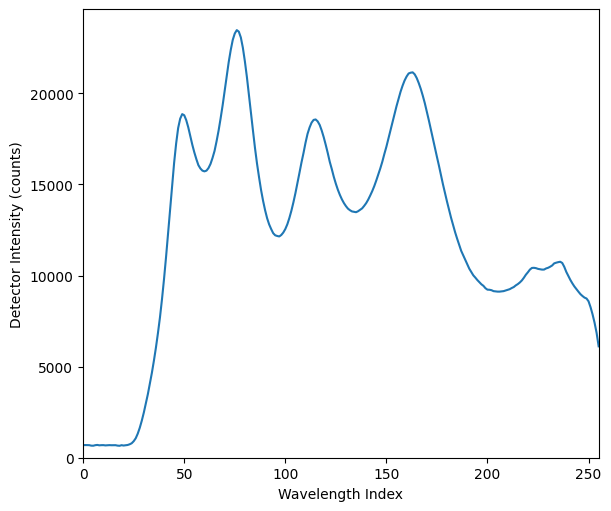

In [10]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)
ax.plot(parsed_frame.detector_intensity)

ax.set_xlabel('Wavelength Index')
ax.set_ylabel('Detector Intensity (counts)')

ax.set_xlim(0,255)
ax.set_ylim(0,None)

## Light Frames Example

In [11]:
parsed_frames = [parse_frame(frame) for frame in frames] # Parse all frames.
parsed_frames = [pf for pf in parsed_frames if pf is not None] # Remove incomplete frames.
light_frames = [pf for pf in parsed_frames if 'LF' in pf.frame_type] # Keep only light frames.

C:\Users\Ian\AppData\Local\Temp\ipykernel_2388\3959943896.py:53: UserWarning: Incomplete frame: SATSLF0405,2025266,22.236786,37.32,0.5227,0.3171,0.1651,0.00,12695,727,1,891,883,875,881,886,877,878,876,881,858,893,877,887,883,885,877,876,885,880,887,892,897,936,949,1006,1111,1280,1524,1864,2224,2671,3170,3690,4266,4900,5530,6234,7046,7939,8933,10043,11243,12543,13894,15200,16456,17504,18321,18853,19108,19068,18785,18401,17904,17427,16996,16616,16329,16120,16008,15985,16005,16143,16384,16702,17121,17616,18211,18891,19627,20420,21210,21986,22681,23248,23590,23732,23673,23372,22797,22040,21165,20177,19186,18206,17259,16432,15664,14949,14356,13841,13398,13033,12773,12554,12434,12387,12389,12452,12618,12790,13048,13414,13796,14252,14778,15305,15868,16457,17002,17547,18011,18341,18659,18813,18844,18752,18535,18227,17875,17431,16994,16541,16100,15666,15314,14940,14663,14433,14222,14073,13949,13832,13797,13754,13752,13780,13852,13947,14074,14230,14387,14625,14889,15146,15454,15791,16150,16534,1

In [12]:
frame_idx = range(1, len(light_frames)+1)
wvl_idx = range(1,257)
counts = [lf.detector_intensity for lf in light_frames]

Text(0.5, 0, 'Detector Intensity (counts)')

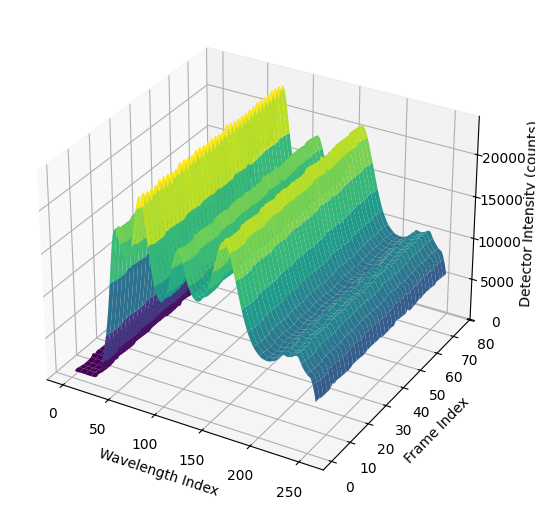

In [13]:
x,y = np.meshgrid(wvl_idx,frame_idx )
z = np.array(counts)

fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True, subplot_kw={'projection':'3d'})
ax.plot_surface(x,y,z, cmap = 'viridis')

ax.set_xlabel('Wavelength Index')
ax.set_ylabel('Frame Index')
ax.set_zlabel('Detector Intensity (counts)')